Train shape: (525886, 787)
shape: (3, 787)
┌─────────┬─────────┬─────────┬──────────┬───┬───────────┬───────────┬──────────┬──────────────────┐
│ bid_qty ┆ ask_qty ┆ buy_qty ┆ sell_qty ┆ … ┆ X779      ┆ X780      ┆ label    ┆ __index_level_0_ │
│ ---     ┆ ---     ┆ ---     ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---      ┆ _                │
│ f64     ┆ f64     ┆ f64     ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64      ┆ ---              │
│         ┆         ┆         ┆          ┆   ┆           ┆           ┆          ┆ datetime[ns]     │
╞═════════╪═════════╪═════════╪══════════╪═══╪═══════════╪═══════════╪══════════╪══════════════════╡
│ 15.283  ┆ 8.425   ┆ 176.405 ┆ 44.984   ┆ … ┆ -0.625428 ┆ -0.553991 ┆ 0.562539 ┆ 2023-03-01       │
│         ┆         ┆         ┆          ┆   ┆           ┆           ┆          ┆ 00:00:00         │
│ 38.59   ┆ 2.336   ┆ 525.846 ┆ 321.95   ┆ … ┆ -0.625832 ┆ -0.554426 ┆ 0.533686 ┆ 2023-03-01       │
│         ┆         ┆         ┆          ┆   ┆  

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


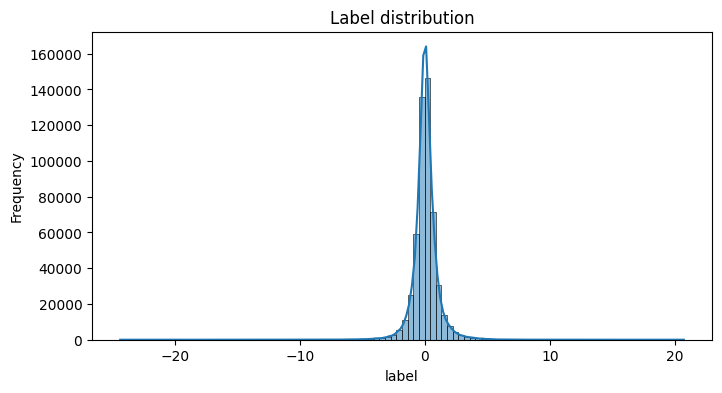

             bid_qty        ask_qty        buy_qty       sell_qty  \
count  525886.000000  525886.000000  525886.000000  525886.000000   
mean        9.967948      10.174161     131.712690     132.660088   
std        15.645712      15.889598     307.184897     309.728730   
min         0.001000       0.001000       0.000000       0.000000   
25%         2.634000       2.678000      26.407000      27.020250   
50%         6.415000       6.538000      57.015000      58.044500   
75%        13.085000      13.330000     127.626000     129.100500   
max      1114.932000    1352.965000   17609.567000   17685.503000   

              volume  
count  525886.000000  
mean      264.372778  
std       588.457585  
min         0.000000  
25%        60.687000  
50%       120.790500  
75%       256.730750  
max     28685.346000  


In [1]:
# Import required libraries
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the training dataset using polars
train = pl.read_parquet("/kaggle/input/drw-crypto-market-prediction/train.parquet")
print("Train shape:", train.shape)
print(train.head(3))

# Step 2: Show column names and total column count
print("First 20 columns:", train.columns[:20])
print("Total columns:", len(train.columns))

# Step 3: Visualize the distribution of the target variable ('label')
label_series = train.select("label").to_pandas()
plt.figure(figsize=(8, 4))
sns.histplot(label_series['label'], bins=100, kde=True)
plt.title("Label distribution")
plt.xlabel("label")
plt.ylabel("Frequency")
plt.show()

# Step 4 (optional): Describe key market-related columns
selected_cols = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
train_df = train.select(selected_cols).to_pandas()
print(train_df.describe())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 420708, number of used features: 5
[LightGBM] [Info] Start training from score 0.025639
RMSE: 1.0402628210088907
MAE: 0.6985856707693652
R2 Score: -0.002034233054525103


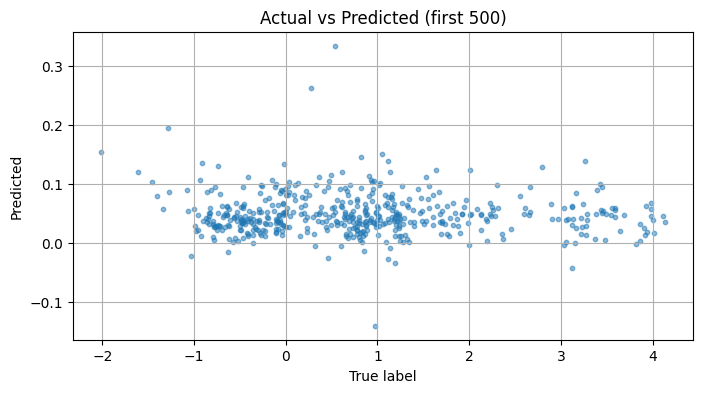

In [2]:
# Import LightGBM and tools
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Select a small subset of features (basic market features only)
features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']

# Convert to pandas for model training
df = train.select(features + ['label']).to_pandas().dropna()

# Define X and y
X = df[features]
y = df['label']

# Split data into training and validation (80% / 20%)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, shuffle=False  # time-series: no shuffle
)

# Build and train model
model = LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_valid)

# Evaluation metrics
print("RMSE:", mean_squared_error(y_valid, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_valid, y_pred))
print("R2 Score:", r2_score(y_valid, y_pred))

# Plot actual vs predicted (scatter)
plt.figure(figsize=(8, 4))
plt.scatter(y_valid[:500], y_pred[:500], alpha=0.5, s=10)
plt.title("Actual vs Predicted (first 500)")
plt.xlabel("True label")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 420708, number of used features: 10
[LightGBM] [Info] Start training from score 0.025642
RMSE: 1.040382811280675
MAE: 0.6985719756411489
R2 Score: -0.0022883047945865265


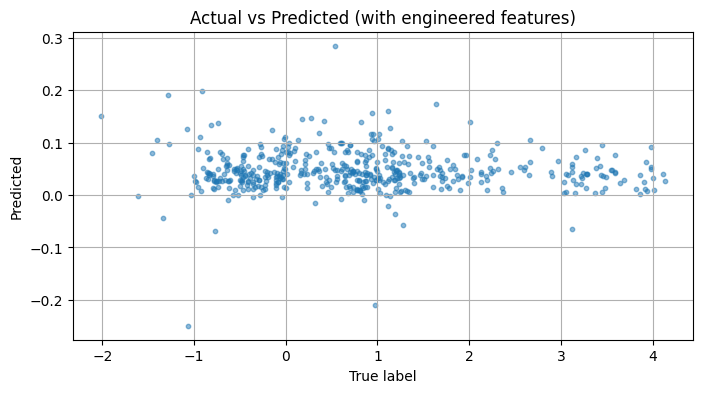

In [3]:
# Copy original DataFrame and add new features
df = train.select([
    'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'label'
]).to_pandas().copy()

# Feature Engineering
df['buy_ratio'] = df['buy_qty'] / (df['buy_qty'] + df['sell_qty'] + 1e-6)
df['ask_bid_ratio'] = df['ask_qty'] / (df['bid_qty'] + 1e-6)
df['log_volume'] = np.log1p(df['volume'])
df['volume_diff'] = df['volume'].diff()
df['spread'] = df['ask_qty'] - df['bid_qty']

# Drop NaN caused by .diff()
df = df.dropna()

# Features to use
features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume',
            'buy_ratio', 'ask_bid_ratio', 'log_volume', 'volume_diff', 'spread']

X = df[features]
y = df['label']

# Split into training and validation (no shuffle)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_valid)
print("RMSE:", mean_squared_error(y_valid, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_valid, y_pred))
print("R2 Score:", r2_score(y_valid, y_pred))

# Plot Actual vs Predicted
plt.figure(figsize=(8, 4))
plt.scatter(y_valid[:500], y_pred[:500], alpha=0.5, s=10)
plt.title("Actual vs Predicted (with engineered features)")
plt.xlabel("True label")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 420708, number of used features: 40
[LightGBM] [Info] Start training from score 0.025642
RMSE: 1.049233762434345
MAE: 0.7022074514634481
R2 Score: -0.019414578255266823


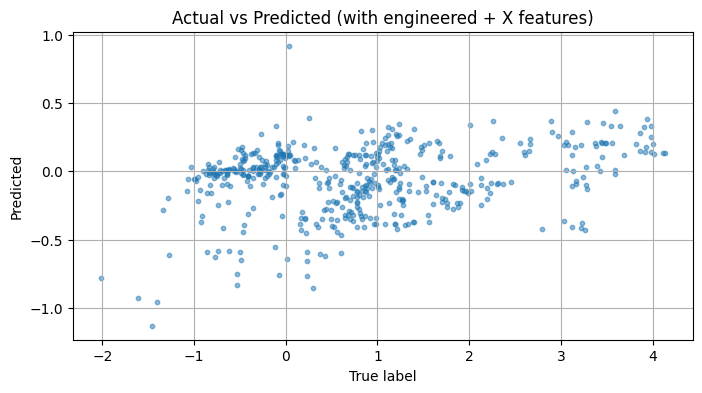

In [4]:
# Load the data using pandas instead of polars
train_df = pd.read_parquet("/kaggle/input/drw-crypto-market-prediction/train.parquet")

# Select columns
anon_features = [f"X{i}" for i in range(1, 31)]
base_features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'label']
columns_to_load = base_features + anon_features

# Create new DataFrame with selected columns
df = train_df[columns_to_load].copy()

# Add engineered features
df['buy_ratio'] = df['buy_qty'] / (df['buy_qty'] + df['sell_qty'] + 1e-6)
df['ask_bid_ratio'] = df['ask_qty'] / (df['bid_qty'] + 1e-6)
df['log_volume'] = np.log1p(df['volume'])
df['volume_diff'] = df['volume'].diff()
df['spread'] = df['ask_qty'] - df['bid_qty']

# Drop NaN
df = df.dropna()

# Final feature list
features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume',
            'buy_ratio', 'ask_bid_ratio', 'log_volume', 'volume_diff', 'spread'] + anon_features

X = df[features]
y = df['label']

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_valid)

# Evaluate
print("RMSE:", mean_squared_error(y_valid, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_valid, y_pred))
print("R2 Score:", r2_score(y_valid, y_pred))

# Plot
plt.figure(figsize=(8, 4))
plt.scatter(y_valid[:500], y_pred[:500], alpha=0.5, s=10)
plt.title("Actual vs Predicted (with engineered + X features)")
plt.xlabel("True label")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 420697, number of used features: 11
[LightGBM] [Info] Start training from score 0.025635
RMSE: 1.0414705373992896
MAE: 0.698863580592305
R2 Score: -0.0044214254226229155


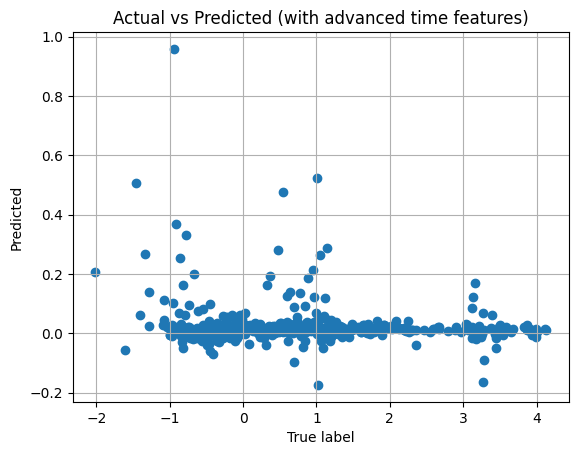

In [5]:
# Select only necessary columns to reduce memory usage
selected_cols = ['buy_qty', 'volume', 'label']
df = train_df[selected_cols].copy()

# Add lag features for buy_qty
df['buy_qty_lag_1'] = df['buy_qty'].shift(1)
df['buy_qty_lag_5'] = df['buy_qty'].shift(5)
df['buy_qty_lag_10'] = df['buy_qty'].shift(10)

# Add rolling mean features for buy_qty
df['buy_qty_ma_3'] = df['buy_qty'].rolling(window=3).mean()
df['buy_qty_ma_5'] = df['buy_qty'].rolling(window=5).mean()
df['buy_qty_ma_10'] = df['buy_qty'].rolling(window=10).mean()
df['buy_qty_ma_15'] = df['buy_qty'].rolling(window=15).mean()

# Add lag and rolling features for volume
df['volume_lag_5'] = df['volume'].shift(5)
df['volume_ma_10'] = df['volume'].rolling(window=10).mean()

# Drop rows with NaN caused by shifting/rolling
df = df.dropna()

# Define feature columns for training
features = ['buy_qty', 'volume',
            'buy_qty_lag_1', 'buy_qty_lag_5', 'buy_qty_lag_10',
            'buy_qty_ma_3', 'buy_qty_ma_5', 'buy_qty_ma_10', 'buy_qty_ma_15',
            'volume_lag_5', 'volume_ma_10']

# Define X and y
X = df[features]
y = df['label']

# Train LightGBM model
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LGBMRegressor()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

# Plot
plt.scatter(y_val[:500], y_pred[:500])
plt.xlabel("True label")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (with advanced time features)")
plt.grid(True)
plt.show()

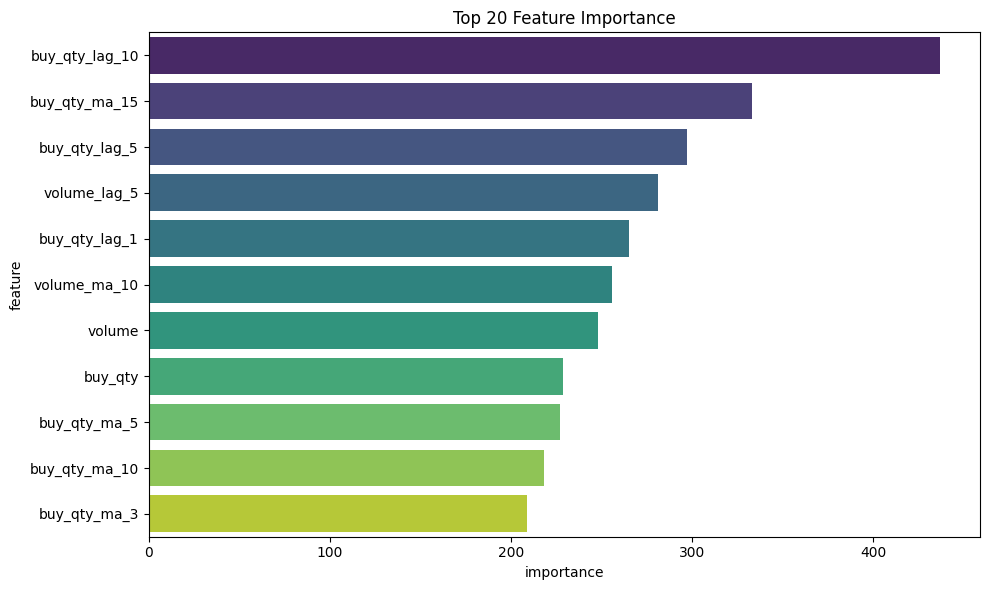


Low-importance features (importance = 0):
[]


In [6]:
# Show feature importance
importances = model.feature_importances_  
feature_names = model.feature_name_       

# Pack into a DataFrame for easier viewing
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values(by='importance', ascending=False)

# Plot top 20 important features
plt.figure(figsize=(10,6))
sns.barplot(data=fi_df.head(20), x='importance', y='feature', palette='viridis')
plt.title("Top 20 Feature Importance")
plt.tight_layout()
plt.show()

# Print low-importance features (optional)
print("\nLow-importance features (importance = 0):")
print(fi_df[fi_df['importance'] == 0]['feature'].tolist())


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 525872, number of used features: 11
[LightGBM] [Info] Start training from score 0.036113
After Feature Filtering
RMSE: 1.0002070424246428
MAE: 0.6354124933548106
R2 Score: 0.01914879913086487


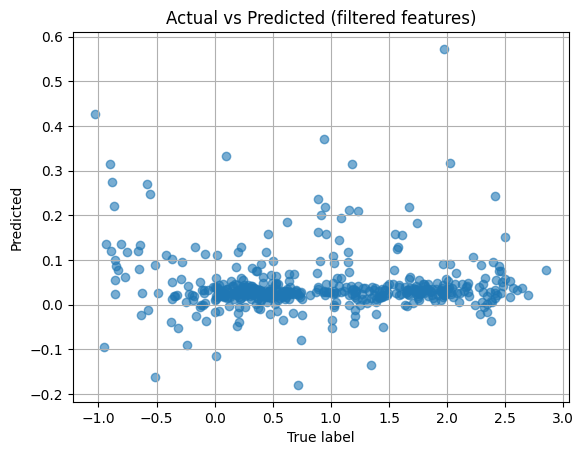

In [7]:
# Step 1: Load feature importance
fi_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Step 2: Filter out features with low importance (e.g., importance <= 5)
important_features = fi_df[fi_df['importance'] > 5]['feature'].tolist()

# Step 3: Create a new training dataset only with important features
X_train_filtered = df[important_features] 
y_train = df['label']                      

# Step 4: Train the model again
from lightgbm import LGBMRegressor
model_filtered = LGBMRegressor(n_estimators=100, random_state=42)
model_filtered.fit(X_train_filtered, y_train)

# Step 5: Predict and evaluate
y_pred_filtered = model_filtered.predict(X_train_filtered)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("After Feature Filtering")
print("RMSE:", mean_squared_error(y_train, y_pred_filtered, squared=False))
print("MAE:", mean_absolute_error(y_train, y_pred_filtered))
print("R2 Score:", r2_score(y_train, y_pred_filtered))

# Step 6: Visualization
import matplotlib.pyplot as plt
plt.scatter(y_train[:500], y_pred_filtered[:500], alpha=0.6)
plt.xlabel('True label')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (filtered features)')
plt.grid(True)
plt.show()


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import polars as pl

# Step 0: Create custom features for train_df
train_df = train_df.copy()

# Basic ratio and spread features
train_df['buy_ratio'] = train_df['buy_qty'] / (train_df['buy_qty'] + train_df['sell_qty'] + 1e-5)
train_df['spread'] = train_df['ask_qty'] - train_df['bid_qty']
train_df['volume_change'] = train_df['volume'].pct_change().fillna(0)

# Lag and rolling features
train_df['buy_qty_lag_1'] = train_df['buy_qty'].shift(1).fillna(0)
train_df['buy_qty_lag_5'] = train_df['buy_qty'].shift(5).fillna(0)
train_df['buy_qty_lag_10'] = train_df['buy_qty'].shift(10).fillna(0)
train_df['buy_qty_ma_3'] = train_df['buy_qty'].rolling(window=3).mean().fillna(0)
train_df['buy_qty_ma_5'] = train_df['buy_qty'].rolling(window=5).mean().fillna(0)
train_df['buy_qty_ma_10'] = train_df['buy_qty'].rolling(window=10).mean().fillna(0)
train_df['buy_qty_ma_15'] = train_df['buy_qty'].rolling(window=15).mean().fillna(0)
train_df['volume_lag_5'] = train_df['volume'].shift(5).fillna(0)
train_df['volume_ma_10'] = train_df['volume'].rolling(window=10).mean().fillna(0)

# Step 1: Load test set using Polars and convert to pandas
test = pl.read_parquet("/kaggle/input/drw-crypto-market-prediction/test.parquet")
test_df = test.to_pandas()

# Step 2: Extract anonymous X features (X1 to X30)
x_cols = [col for col in train_df.columns if col.startswith('X') and '_' not in col]

# Step 3: Standardize X features for PCA
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train_df[x_cols])
x_test_scaled = scaler.transform(test_df[x_cols])

# Step 4: Perform PCA and keep top 5 components
pca = PCA(n_components=5, random_state=42)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# Step 5: Add PCA components to train and test sets
for i in range(1, 6):
    train_df[f'PCA_{i}'] = x_train_pca[:, i - 1]
    test_df[f'PCA_{i}'] = x_test_pca[:, i - 1]

# Step 6: Add custom features to test_df (simplified to avoid memory issues)
test_df['buy_ratio'] = test_df['buy_qty'] / (test_df['buy_qty'] + test_df['sell_qty'] + 1e-5)
test_df['spread'] = test_df['ask_qty'] - test_df['bid_qty']
test_df['volume_change'] = test_df['volume'].pct_change().fillna(0)

# Remove raw X columns from test_df to reduce memory
test_df.drop(columns=x_cols, inplace=True)

# Add placeholder values for lag/rolling features (not available in test)
lag_rolling_cols = [
    'buy_qty_lag_1', 'buy_qty_ma_3', 'buy_qty_ma_5',
    'buy_qty_lag_5', 'buy_qty_lag_10', 'buy_qty_ma_10',
    'buy_qty_ma_15', 'volume_lag_5', 'volume_ma_10'
]
test_df = test_df.assign(**{col: 0 for col in lag_rolling_cols})

# Step 7: Define the final feature list
feature_cols = [
    'buy_ratio', 'spread', 'volume_change',
    'buy_qty_lag_1', 'buy_qty_ma_3', 'buy_qty_ma_5',
    'buy_qty_lag_5', 'buy_qty_lag_10', 'buy_qty_ma_10',
    'buy_qty_ma_15', 'volume_lag_5', 'volume_ma_10',
    'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5'
]

print("Final feature list defined. Total features:", len(feature_cols))


Final feature list defined. Total features: 17


In [9]:
from lightgbm import LGBMRegressor

# Step 1: Prepare training features and target
X_train = train_df[feature_cols]
y_train = train_df['label']

# Step 2: Prepare test features
X_test = test_df[feature_cols]

# Step 3: Train the LightGBM model
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 5: Load sample submission file
sample = pd.read_csv("/kaggle/input/drw-crypto-market-prediction/sample_submission.csv")

# Step 6: Create submission DataFrame
submission = pd.DataFrame({
    "ID": sample["ID"],
    "prediction": y_pred
})

submission.to_csv("submission.csv", index=False)
print("Prediction complete. File saved as submission.csv.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 525886, number of used features: 17
[LightGBM] [Info] Start training from score 0.036126
Prediction complete. File saved as submission.csv.
